In [158]:
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from joblib import dump
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from datetime import datetime
%matplotlib inline

In [5]:
DOB_approved_permits = pd.read_csv('https://data.cityofnewyork.us/api/views/rbx6-tga4/rows.csv?accessType=DOWNLOAD', low_memory=False)
print(f"Dataframe shape: {DOB_approved_permits.shape}", end="\n"*3)
print(f"features: {DOB_approved_permits.columns}", end="\n"*3)

Dataframe shape: (369245, 35)


features : None




In [6]:
try: 
    BIN_NTA = pd.read_csv("df_bin_NTA.csv")
except: 
    DOB_JOB_AP_FIL = pd.read_csv("https://data.cityofnewyork.us/api/views/ic3t-wcy2/rows.csv?accessType=DOWNLOAD", low_memory=False) #https://data.cityofnewyork.us/Housing-Development/DOB-Job-Application-Filings/ic3t-wcy2
    BIN_NTA = DOB_JOB_AP_FIL.groupby(by=["Bin #","GIS_NTA_NAME"]).count().reset_index().loc[:,["Bin #","GIS_NTA_NAME"]]

print(f"Dataframe shape: {BIN_NTA.shape}", end="\n"*3)
print(f"features: {BIN_NTA.columns}", end="\n"*3)

Dataframe shape: (370150, 3)


features: Index(['Unnamed: 0', 'Bin #', 'GIS_NTA_NAME'], dtype='object')




In [63]:
# build fataframe 
DOB_approved_permits.rename(columns={'Filing Reason': 'PERMIT', 'Bin': 'BIN', 'Applicant License #': 'LICENSE'}, inplace=True)
DOB_approved_permits = DOB_approved_permits[['PERMIT', 'BIN', 'LICENSE']]
BIN_NTA.rename(columns={"Bin #": "BIN"}, inplace=True)
df = pd.merge(DOB_approved_permits, BIN_NTA, on="BIN")

In [65]:
# Casting data types
df.loc[:,['BIN', 'LICENSE']] = df.loc[:,['BIN', 'LICENSE']].astype(dtype='int32')
df.loc[:,['PERMIT', 'GIS_NTA_NAME']] = df.loc[:,['PERMIT', 'GIS_NTA_NAME']].astype(dtype='object')

In [23]:
# Feature engineering : get reworks index by feature, one by time.
def get_rework_index_by_feature(df_in, features_to_index):
  df = df_in.copy(deep=True)
  df = df.assign(one_hot=1) # add ones columns
  df = df.groupby(features_to_index).count() # groupby features
  rework_index=[]
  for k0, v0 in df.groupby(level=0): # loop by first index
    start=1  # by default allways has at least one start work permits
    renew=0  # count times to renew work permits
    for i, k in v0.groupby(level=1): # Loop por i = Filing reason
      if i == "Initial Permit" and v0.one_hot[k0,i] != 1: # Just add if is major than one.
        start=v0.one_hot[k0,i]

      elif i != "Initial Permit": #Whatever other kind of permits, its consider reworks.
        renew+=v0.one_hot[k0,i]

    rework_index.append([k0,round(float(renew/start),4)])

  df_aux = pd.DataFrame(rework_index, columns=[features_to_index[0],"rework_index_"+features_to_index[0]])
  df_in = df_in.merge(df_aux, on=features_to_index[0])

  return df_in

In [64]:
# set features and target
features = ['BIN', 'LICENSE', 'GIS_NTA_NAME','REWORK_INDEX']
target = 'REWORK_INDEX'

In [66]:
# build target
df2 = get_rework_index_by_feature(df,['BIN', 'PERMIT'])
df3 = get_rework_index_by_feature(df2,['LICENSE', 'PERMIT'])
df4 = get_rework_index_by_feature(df3,['GIS_NTA_NAME', 'PERMIT'])
df[target] = df4.loc[:,["rework_index_BIN","rework_index_GIS_NTA_NAME","rework_index_LICENSE"]].sum(axis=1)
# clean auto index generated by merge
df = df[features]
df

,BIN,LICENSE,GIS_NTA_NAME,REWORK_INDEX
0,3335229,16217,Fort Greene,5.2393
1,3335229,16217,Fort Greene,5.2393
2,3335229,16217,Fort Greene,5.2393
3,3335229,16217,Fort Greene,5.2393
4,3335229,16217,Fort Greene,5.2393
...,...,...,...,...
340467,4194107,1826,Richmond Hill,1.3549
340468,3071411,616836,Bushwick South,1.3549
340469,3059877,617232,Williamsburg,2.1882
340470,1087278,617449,SoHo-TriBeCa-Civic Center-Little Italy,2.1882


In [68]:
# features preprocessing

df.drop_duplicates(subset=['BIN','LICENSE','GIS_NTA_NAME','REWORK_INDEX'] ,inplace=True)
df = pd.concat([df,pd.get_dummies(df.GIS_NTA_NAME)], axis=1)
df["REWORK_INDEX_BINNING"] = pd.cut(df.REWORK_INDEX, [ 0, 1, 2, 3, 100000], labels=False , retbins=True, right=True)[0]

print(f"Dataframe shape: {df.shape}", end="\n"*3)
print(f"features: {df.columns}", end="\n"*3)

Dataframe shape: (260565, 199)


features: Index(['BIN', 'LICENSE', 'GIS_NTA_NAME', 'REWORK_INDEX', 'Airport',
       'Allerton-Pelham Gardens', 'Annadale-Huguenot-Prince's Bay-Eltingville',
       'Arden Heights', 'Astoria', 'Auburndale',
       ...
       'Windsor Terrace', 'Woodhaven', 'Woodlawn-Wakefield', 'Woodside',
       'Yorkville', 'park-cemetery-etc-Bronx', 'park-cemetery-etc-Brooklyn',
       'park-cemetery-etc-Manhattan', 'park-cemetery-etc-Queens',
       'REWORK_INDEX_BINNING'],
      dtype='object', length=199)




## Iniciamos proceso de modelado de ML

In [123]:
#set X and y, for train and test.
df_X = df.drop(columns=['GIS_NTA_NAME', 'REWORK_INDEX', 'REWORK_INDEX_BINNING'])
df_y = df.REWORK_INDEX_BINNING
X_train, X_test, y_train, y_test= model_selection.train_test_split(df_X, df_y, test_size=0.2, random_state=7)
print('binning target dsitribution')

for i in range(4):
    print(f'{i} {df_y.where(df_y==i).count()} ==> {df_y.where(df_y==i).count()/df_y.count(): .0%}')


binning target dsitribution
0 88116 ==>  34%
1 106548 ==>  41%
2 40389 ==>  16%
3 25512 ==>  10%


In [125]:
# Build model|

xgb_model = xgb.XGBClassifier(n_jobs=multiprocessing.cpu_count() // 2,)
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=2, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [126]:
# make predictions

predictions = xgb_model.predict(X_test)
predictions_train = xgb_model.predict(X_train)

In [127]:
# Reporting  

hard_core_0 =pd.Series(np.zeros(len(X_train)))
hard_core_1 =pd.Series(np.ones(len(X_train)))
hard_core_2 =pd.Series(2*np.ones(len(X_train)))
hard_core_3 =pd.Series(3*np.ones(len(X_train)))

print("--------Confusion matrix: MODEL RUN OVER y_train RESULTS---------------")
print(classification_report(y_train, predictions_train))
print("--------Confusion matrix: MODEL RUN OVER y_test RESULTS---------------")
print(classification_report(y_test, predictions))
print("--------Confusion matrix: METRICS OVER HARD CODE REWORK_INDEX_BINNING= 0  RESULTS---------------")
print(classification_report(y_train, hard_core_0))
print("--------Confusion matrix: METRICS OVER HARD CODE REWORK_INDEX_BINNING= 1  RESULTS---------------")
print(classification_report(y_train, hard_core_1))
print("--------Confusion matrix: METRICS OVER HARD CODE REWORK_INDEX_BINNING= 2  RESULTS---------------")
print(classification_report(y_train, hard_core_2))
print("--------Confusion matrix: METRICS OVER HARD CODE REWORK_INDEX_BINNING= 3  RESULTS---------------")
print(classification_report(y_train, hard_core_3))


--------Confusion matrix: MODEL RUN OVER y_train RESULTS---------------
              precision    recall  f1-score   support

           0       0.57      0.18      0.27     70463
           1       0.43      0.94      0.59     85149
           2       0.82      0.02      0.03     32358
           3       0.65      0.04      0.07     20482

    accuracy                           0.45    208452
   macro avg       0.62      0.29      0.24    208452
weighted avg       0.56      0.45      0.35    208452

--------Confusion matrix: MODEL RUN OVER y_test RESULTS---------------
              precision    recall  f1-score   support

           0       0.44      0.14      0.21     17653
           1       0.42      0.91      0.58     21399
           2       0.46      0.01      0.02      8031
           3       0.51      0.03      0.05      5030

    accuracy                           0.42     52113
   macro avg       0.46      0.27      0.21     52113
weighted avg       0.44      0.42      0.3

C:\Users\Compumundo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Compumundo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Compumundo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.34      1.00      0.51     70463
           1       0.00      0.00      0.00     85149
           2       0.00      0.00      0.00     32358
           3       0.00      0.00      0.00     20482

    accuracy                           0.34    208452
   macro avg       0.08      0.25      0.13    208452
weighted avg       0.11      0.34      0.17    208452

--------Confusion matrix: METRICS OVER HARD CODE REWORK_INDEX_BINNING= 1  RESULTS---------------


C:\Users\Compumundo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Compumundo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Compumundo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     70463
           1       0.41      1.00      0.58     85149
           2       0.00      0.00      0.00     32358
           3       0.00      0.00      0.00     20482

    accuracy                           0.41    208452
   macro avg       0.10      0.25      0.15    208452
weighted avg       0.17      0.41      0.24    208452

--------Confusion matrix: METRICS OVER HARD CODE REWORK_INDEX_BINNING= 2  RESULTS---------------


C:\Users\Compumundo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Compumundo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Compumundo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     70463
           1       0.00      0.00      0.00     85149
           2       0.16      1.00      0.27     32358
           3       0.00      0.00      0.00     20482

    accuracy                           0.16    208452
   macro avg       0.04      0.25      0.07    208452
weighted avg       0.02      0.16      0.04    208452

--------Confusion matrix: METRICS OVER HARD CODE REWORK_INDEX_BINNING= 3  RESULTS---------------


C:\Users\Compumundo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     70463
           1       0.00      0.00      0.00     85149
           2       0.00      0.00      0.00     32358
           3       0.10      1.00      0.18     20482

    accuracy                           0.10    208452
   macro avg       0.02      0.25      0.04    208452
weighted avg       0.01      0.10      0.02    208452



C:\Users\Compumundo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Compumundo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

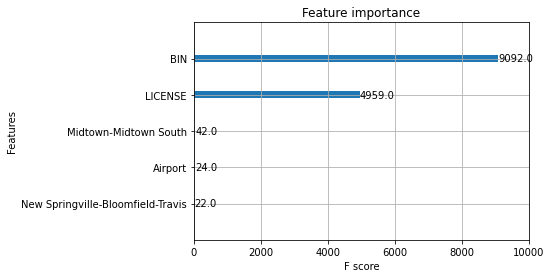

In [128]:
xgb.plot_importance(xgb_model, max_num_features = 5)

In [156]:
# Now train a Random forest with hyper parameters taked from autoML 

clf = RandomForestClassifier(bootstrap=False, max_features=1, min_samples_split=16,
                         n_estimators=512, n_jobs=-1, random_state=1,
                         warm_start=True)

In [157]:
# train the model

clf.fit(X_train,y_train)


RandomForestClassifier(bootstrap=False, max_features=1, min_samples_split=16,
                       n_estimators=512, n_jobs=-1, random_state=1,
                       warm_start=True)

In [170]:
# predictions

predictions = clf.predict(X_test)
predictions_train = clf.predict(X_train)


In [171]:
# reporting 

print("--------Confusion matrix: MODEL RF RUN OVER y_train RESULTS---------------")
print(classification_report(y_train, predictions_train))
print("--------Confusion matrix: MODEL RF RUN OVER y_test RESULTS---------------")
print(classification_report(y_test, predictions))

--------Confusion matrix: MODEL RF RUN OVER y_train RESULTS---------------
              precision    recall  f1-score   support

           0       0.73      0.79      0.76     70463
           1       0.71      0.84      0.77     85149
           2       0.77      0.50      0.61     32358
           3       0.82      0.44      0.57     20482

    accuracy                           0.73    208452
   macro avg       0.76      0.64      0.68    208452
weighted avg       0.74      0.73      0.72    208452

--------Confusion matrix: MODEL RF RUN OVER y_test RESULTS---------------
              precision    recall  f1-score   support

           0       0.42      0.45      0.44     17653
           1       0.45      0.56      0.50     21399
           2       0.27      0.15      0.19      8031
           3       0.28      0.11      0.16      5030

    accuracy                           0.42     52113
   macro avg       0.35      0.32      0.32     52113
weighted avg       0.40      0.42   

In [169]:
# Saving model 
print("Saving models...\n\n")
try:
    path = "model-Version-" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S") + ".json"
    xgb_model.save_model(path)
    print("Model SCGBOOST Saved OK\n\n")
except():
    print('MODEL NOT SAVED AT DISK')
    pass

# Saving model 
print("Saving models...\n\n")
try:
    path = "RandomForest" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S") + ".joblib"
    dump(clf, path)
    print("Model RandomForest Saved OK\n\n")
except():
    print('MODEL RandomForest NOT SAVED AT DISK')
    pass


Saving models...


Model SCGBOOST Saved OK


Saving models...


Model RandomForest Saved OK


